In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Load the data
file_path = "../SPY_section_1.csv"
df = pd.read_csv(file_path)

In [7]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out
    
    
sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [9]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [10]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [11]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1420, Val: 304, Test: 295
(2029, 11)


In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [13]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30

C:\Users\ROG\AppData\Local\Temp/ipykernel_11856/667235474.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path))
d:\Anac


===== Evaluation Results =====
Test Loss: 36.7081
Test MAE: 4.6086
Average Error Percentage: 4.13%
Largest Error Percentage: 13.03%


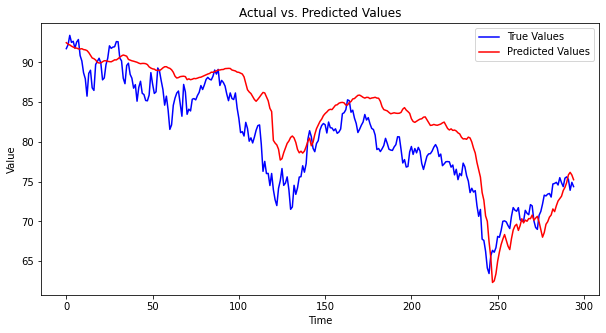

In [ ]:
# Define paths
LSTM_model_path = "../lstm_codes/lstm_models/lstm_section_1.pth"
# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        
        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)
        
        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [15]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [16]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [17]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [18]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [19]:
autoencoder_model_path = "../autoencoder_codes/autoencoder_models/autoencoder_section_1.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path))

C:\Users\ROG\AppData\Local\Temp/ipykernel_11856/2619544055.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model

<All keys matched successfully>

In [20]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0016, MAE: 0.0273, REE: 0.0377, Euclidean Distance: 0.1188, Average Error: 2.8993%


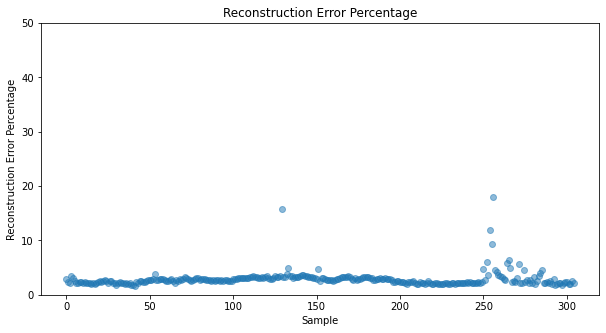

In [21]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [22]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()
        
#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)
        
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)
        
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
        
#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)



import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)

In [23]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()
    
# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [24]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [25]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()
    
# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])
    

# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



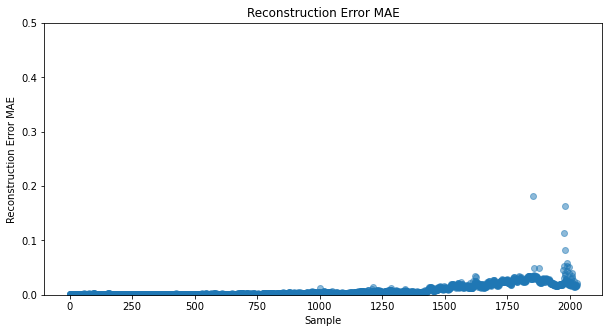

In [26]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [27]:
reconstruction_error_arr[0]

array([0.00189878, 0.00180705, 0.00187238, 0.00172222, 0.00195921,
       0.00198496, 0.00210326, 0.00231762, 0.00201488, 0.00175625])

In [28]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [29]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [30]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1413, Val: 302, Test: 304


In [31]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset

# Directory to save the models
save_dir = "uni_input_trials"
os.makedirs(save_dir, exist_ok=True)

# Number of trials
num_trials = 10

# Training parameters
input_size = 1
hidden_size = 32
dropout_rate = 0.0
learning_rate = 0.0001
num_epochs = 500
patience = 20

# To store predictions for each trial
all_predictions = {}

for trial in range(num_trials):
    print(f"Starting trial {trial + 1}/{num_trials}")

    # Initialize model, loss function, and optimizer
    bias_model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    best_epoch = 0
    best_model_state = None  # Store best model state

    # Training loop
    for epoch in range(num_epochs):
        bias_model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = bias_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation loop
        bias_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = bias_model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = bias_model.state_dict()  # Save the best model state

        elif epoch - best_epoch >= patience:
            print(f"Trial {trial + 1}: Stopping early at epoch {epoch}")
            break

        print(f"Trial {trial + 1}, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model from this trial
    if best_model_state is not None:
        model_filename = os.path.join(save_dir, f"bias_model_trial_{trial + 1}.pth")
        torch.save(best_model_state, model_filename)
        print(f"Saved model for Trial {trial + 1} to {model_filename}")

        # Load best model and generate predictions
        bias_model.load_state_dict(best_model_state)
        bias_model.eval()
        
        with torch.no_grad():
            combined_X = torch.cat((X_train, X_val, X_test), dim=0).to(device)
            y_pred = bias_model(combined_X).cpu().numpy()

        outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))
        
        # Store predictions for this trial
        all_predictions[f"trial_{trial + 1}"] = outputs_unscaled

print("Completed all trials and saved models & predictions!")

        

        

Starting trial 1/10


Trial 1, Epoch 0, Train Loss: 0.7948, Val Loss: 6.7066
Trial 1, Epoch 1, Train Loss: 0.7732, Val Loss: 7.4428
Trial 1, Epoch 2, Train Loss: 0.7591, Val Loss: 8.1353
Trial 1, Epoch 3, Train Loss: 0.7493, Val Loss: 8.7611
Trial 1, Epoch 4, Train Loss: 0.7421, Val Loss: 9.1704
Trial 1, Epoch 5, Train Loss: 0.7368, Val Loss: 9.5201
Trial 1, Epoch 6, Train Loss: 0.7329, Val Loss: 9.9449
Trial 1, Epoch 7, Train Loss: 0.7298, Val Loss: 10.2891
Trial 1, Epoch 8, Train Loss: 0.7274, Val Loss: 10.4778
Trial 1, Epoch 9, Train Loss: 0.7256, Val Loss: 10.6443
Trial 1, Epoch 10, Train Loss: 0.7242, Val Loss: 10.8113
Trial 1, Epoch 11, Train Loss: 0.7229, Val Loss: 10.9733
Trial 1, Epoch 12, Train Loss: 0.7221, Val Loss: 11.1012
Trial 1, Epoch 13, Train Loss: 0.7213, Val Loss: 11.2401
Trial 1, Epoch 14, Train Loss: 0.7204, Val Loss: 11.4188
Trial 1, Epoch 15, Train Loss: 0.7202, Val Loss: 11.3492
Trial 1, Epoch 16, Train Loss: 0.7196, Val Loss: 11.2787
Trial 1, Epoch 17, Train Loss: 0.7191, Val Loss:

In [32]:
# # Get predictions on entire set
# combined_X = torch.cat((X_train, X_val, X_test), dim=0)
# combined_y = torch.cat((y_train, y_val, y_test), dim=0)
# # convert x_scaled to tensor
# X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
# bias_model.eval()
# with torch.no_grad():
#     y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

In [33]:
# # Unscale outputs
# outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

In [34]:
# new_df["Bias_Pred"] = outputs_unscaled
# new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

In [35]:
# original_error_percent = np.mean(np.abs(new_df["Bias"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100
# corrected_error_percent = np.mean(np.abs(new_df["Target"] - new_df["Corrected_LSTM_Pred"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100

# print(f"Original Error Percentage (entire dataset): {original_error_percent:.4f}%")
# print(f"Corrected Error Percentage (entire dataset): {corrected_error_percent:.4f}%")

In [36]:
# # plot graph of target vs original vs predicted
# plt.figure(figsize=(25, 15))
# plt.plot(new_df["Target"], label='Target', color='blue')
# plt.plot(new_df["LSTM_Pred"], label='Original Prediction', color='red')
# plt.plot(new_df["Corrected_LSTM_Pred"], label='Corrected Prediction', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Target vs. Original vs. Corrected Prediction')
# plt.legend()
# plt.show()

In [37]:
# # only plot test dataset
# plt.figure(figsize=(25, 15))
# plt.plot(new_df["Target"].iloc[train_size + val_size:], label='Target', color='blue')
# plt.plot(new_df["LSTM_Pred"].iloc[train_size + val_size:], label='Original Prediction', color='red')
# plt.plot(new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:], label='Corrected Prediction', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Target vs. Original vs. Corrected Prediction (Test Dataset)')
# plt.legend()
# plt.show()

In [38]:
# # original error percent of test set
# original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
# corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

# print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
# print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

In [50]:
# concat y values of train test and val 
combined_y = torch.cat((y_train, y_val, y_test), dim=0)
combined_y = combined_y.cpu().numpy()

In [62]:
# Create empty DataFrame
temp_df = pd.DataFrame()

# Convert all predictions to a DataFrame
for i, predictions in all_predictions.items():
    temp_df[i] = pd.Series(predictions.flatten())  # Convert array to Series

print(temp_df.head())


    trial_1   trial_2   trial_3   trial_4   trial_5   trial_6   trial_7  \
0 -0.060514 -0.082391 -0.089907 -0.050322 -0.055196 -0.067923 -0.061682   
1 -0.166472 -0.224171 -0.195078 -0.154992 -0.184516 -0.207093 -0.185330   
2 -0.143063 -0.199136 -0.173407 -0.128585 -0.154196 -0.181383 -0.161334   
3 -0.101757 -0.144691 -0.135166 -0.087362 -0.101553 -0.122992 -0.112469   
4 -0.070351 -0.096370 -0.103697 -0.058567 -0.065780 -0.080496 -0.073281   

    trial_8   trial_9  trial_10  
0 -0.137108 -0.069328 -0.059242  
1 -0.205713 -0.173578 -0.200628  
2 -0.193125 -0.149012 -0.169126  
3 -0.169335 -0.112054 -0.111993  
4 -0.144288 -0.079083 -0.071287  


In [67]:
temp_df["LSTM_prediction_original"] = new_df["LSTM_Pred"]
temp_df["Target"] = new_df["Target"]


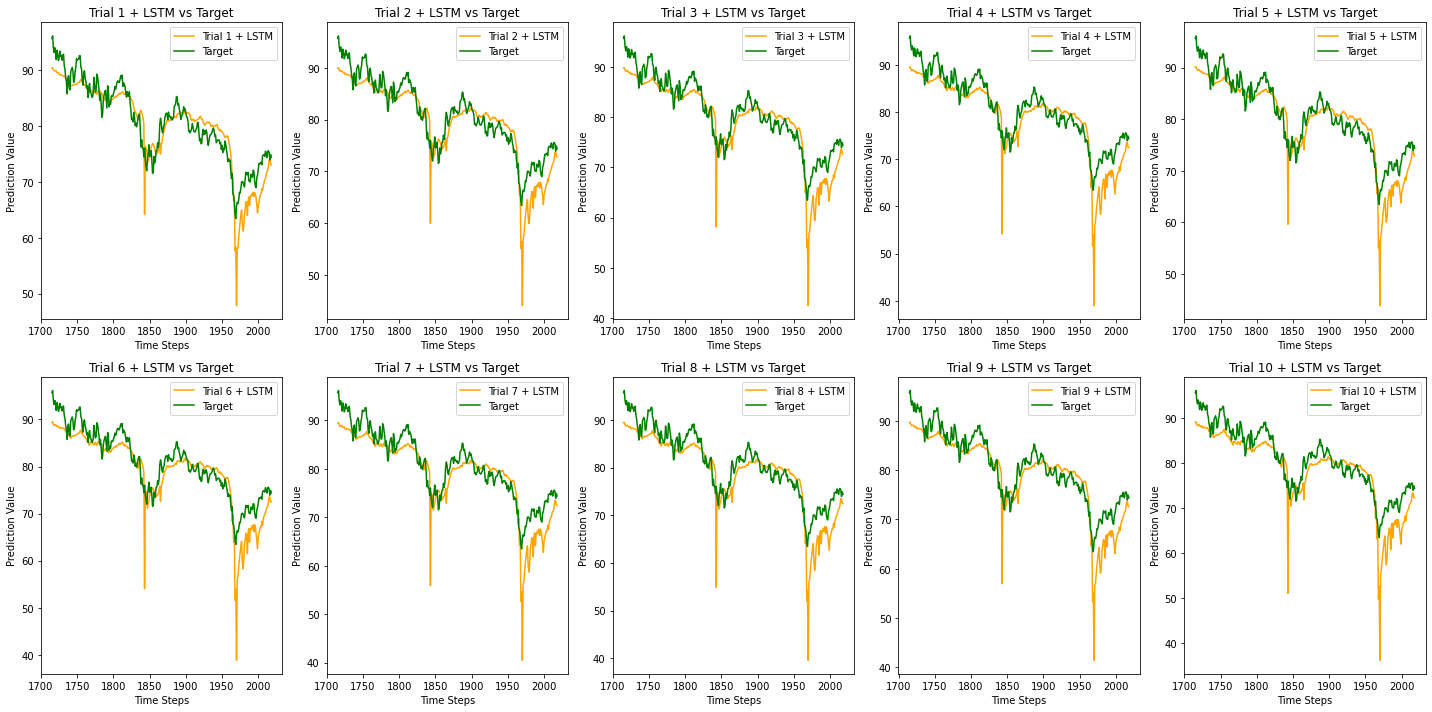

In [71]:
import matplotlib.pyplot as plt

# Define number of trials
num_trials = 10

# Define the test set portion
test_set = temp_df.iloc[train_size + val_size:]

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Iterate over trials and plot each in a separate subplot
for i in range(num_trials):
    trial_col = f'trial_{i+1}'
    
    ax = axes[i]  # Get the current subplot

    # Compute LSTM original + trial prediction for test set only
    corrected_prediction = test_set['LSTM_prediction_original'] + test_set[trial_col]

    # Plot LSTM Original + Bias-Corrected prediction (current trial)
    ax.plot(test_set.index, corrected_prediction, label=f'Trial {i+1} + LSTM', color='orange')

    # Plot Target values for test set
    ax.plot(test_set.index, test_set['Target'], label='Target', color='green')

    # Title and legend
    ax.set_title(f'Trial {i+1} + LSTM vs Target')
    ax.legend()
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Prediction Value')

# Adjust layout
plt.tight_layout()
plt.show()


In [72]:
# print average error for each trial over the test set
for i in range(num_trials):
    trial_col = f'trial_{i+1}'
    error = np.mean(np.abs(test_set['Target'] - (test_set['LSTM_prediction_original'] + test_set[trial_col])) / (np.abs(test_set['Target']) + 1e-8)) * 100
    print(f"Trial {i+1} Average Error: {error:.4f}%")

Trial 1 Average Error: 3.2378%
Trial 2 Average Error: 3.4404%
Trial 3 Average Error: 3.5530%
Trial 4 Average Error: 3.7661%
Trial 5 Average Error: 3.3972%
Trial 6 Average Error: 3.8015%
Trial 7 Average Error: 3.7410%
Trial 8 Average Error: 3.7885%
Trial 9 Average Error: 3.6216%
Trial 10 Average Error: 4.0472%


In [74]:
# print original error of lstm from new_df
original_error_percent = np.mean(np.abs(new_df["Bias"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100
print(f"Original Error Percentage (entire dataset): {original_error_percent:.4f}%")

# print original error of lstm from new_df
original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")

Original Error Percentage (entire dataset): 2.1533%
Original Error Percentage (Test Dataset): 4.0399%
